# Eksamen MIEVU 4020, våren 2022
## Del 2

## Oppgave 4

I denne oppgaven er vi gitt et datasett $\mathcal{T}_{\mathrm{Train}} = \{(x_{1},y_{1}), \ldots, (x_{100}, y_{100}) \} \subset \mathbb{R} \times \mathbb{R}$. Datasettet er visualisert nedenfor.

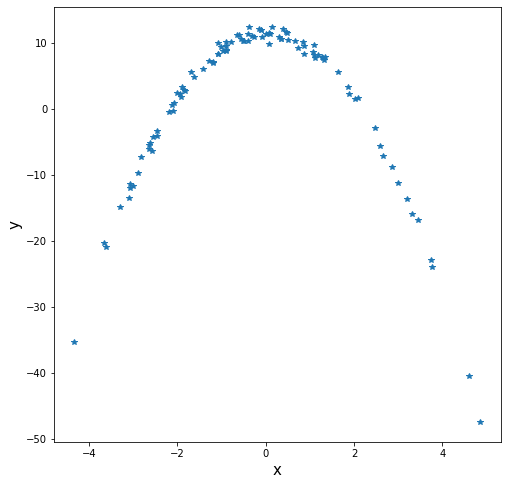

In [1]:
import torch
import os
import matplotlib.pyplot as plt

fname = os.path.join('/itf-fi-ml/shared/MIEVU4020/v22/data/oppgave4', 'data.pt')
x,y = torch.load(fname)
x_numpy = x.numpy()
y_numpy = y.numpy()

plt.figure(figsize=(8,8))
plt.plot(x_numpy, y_numpy, '*')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.show()

### Oppgave 4a
Vi ser at dataene ser ut til å følge en model 
$$y = a x^2 + b,$$
hvor $a$ og $b$ er reele tall. Vi ønsker å estimere tallene $a$ og $b$, slik at vi kan predikere $y$, gitt ulike verdier for $x$. Finn gode verdier for $a$ og $b$ ved å minimere funksjonen 
$$
\Gamma(a,b) = \sum_{i=1}^{100} (ax_{i}^{2} +b - y_{i})^2
$$

### Oppgave 4b
Bruk verdiene for $a$ og $b$ som du fant i oppgave 4a, og plot funksjonen $y=ax^2+b$ sammen med dataene. For hvilke verdier av $x$ vil dette være en rimelig modell? 

Hvis du ikke fant verdier for $a$ og $b$ i oppgave 4a, bruk $a=-2.47$ og $b=11.41$.

## Oppgave 5.

I denne oppgaven skal dere trene et nevralt nettverk til å fjerne Gaussisk støy fra bilder. Deler av koden er allerede implementert, og det skal ikke være behov for å gjøre endringer i denne koden.

Oppgaven inneholder mye kode, men det er bare en liten del av denne koden dere trenger å gjøre endringer i. Det er tydelig markert nedenfor.

#### Datasett klasse
Klassen nedenfor laster inn dataene. Det er ikke nødvendig å endre denne koden.

In [1]:
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

src_data = '/itf-fi-ml/shared/MIEVU4020/v22/data'

class ImageNoisyDataset(torch.utils.data.Dataset):
    def __init__(self, root, noise_level, *args,**kwargs):
        """Create a dataset object, which loads clean and noisy images
        
        Attributtes
        -----------
        root (str): Path to data
        noise_level (float): Strength of the noise.
        """
        
        super().__init__(*args,**kwargs)
        self.root = root
        self.noise_level = noise_level
        
        imagefiles = [f for f in os.listdir(root) if '.png' in f]
        
        self.N = len(imagefiles)
        
        self.targets = []
        for i in range(self.N):
            fname = os.path.join(root, f'sample_{i:04}.png')
            tar = Image.open(fname)
            tar = np.array(tar, dtype=np.float32)/255 # Scale each pixel to [0,1]
            tar = torch.from_numpy(tar)
            tar = tar.unsqueeze(0) # Change shape from [256,256] to [1, 256, 256]
            
            self.targets.append(tar)
    
    def __getitem__(self, idx):
        tar = self.targets[idx]
        inp = tar + self.noise_level*torch.randn_like(tar)
        return inp, tar
    
    def __len__(self):
        return self.N
    
noise_level = 0.05
batch_size = 100
shuffle = True

training_data = ImageNoisyDataset(os.path.join(src_data, 'train'), noise_level=noise_level)
val_data = ImageNoisyDataset(os.path.join(src_data, 'val'), noise_level=noise_level)
test_data = ImageNoisyDataset(os.path.join(src_data, 'test'), noise_level=noise_level)

train_dataloader =  torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=shuffle)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Oppgave 5a
Lag et konvolusjonsnettverk for å fjerne støy fra bilder. Nettverket skal: 
* bestå av minst fire konvolusjonslag
* skal bruke minst en residual (skip) connection.

In [ ]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Lag alle nettverkslagene. Pass på at dimensjonene blir riktige.
    
    def forward(self, z):
        # Spesifiser hvordan nettverkslagene skal henge sammen.
        
        

Koden nedenfor lager en instans av nettverket og flytter vektene til GPUen hvis den er tilgjengelig. Du trenger ikke å endre denne koden.

In [ ]:
model = NeuralNetwork()
print(model)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device) # Move model parameters to the device

Koden nedenfor definierer treningstegene til det nevrale nettverket. Du trenger ikke endre denne koden.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def validation_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            
            val_loss += loss_fn(pred, y).item()


    val_loss /= num_batches
    print(f"Validation Error: \nAvg loss: {val_loss:>8f} \n")

### Oppgave 5b
Gjør følgende:
* Velg hvor mange iteratsjoner (epochs) med treningen du skal kjøre.
* Tren det nevrale nettverket.
* Sjekk om nettverket klarer å fjerne støyen i bildene. Kommenter resultatet.

Man kan få full uttelling på denne oppgaven, selv om man ikke finner et nettverk som gjør en spesielt bra jobb.

Hint: Det kan være nødvendig å restarte notebooken (restart kernel) og kjøre oppgaven fra start av hvis du ønsker å trene nettverket på nytt.

In [ ]:
epochs = # Fyll inn antall epochs
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    validation_loop(val_dataloader, model, loss_fn, device)
print("Done!")

### Kode for å teste det ferdig trente nevrale nettverket

In [ ]:

X, Y = next(iter(test_dataloader));
pred = model(X.to(device));
pred = pred.cpu()
i = 0;
x = X[i].squeeze().detach().numpy()
y = Y[i].squeeze().detach().numpy()
p = pred[i].squeeze().detach().numpy()

figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 1

figure.add_subplot(rows, cols, 1)
plt.title('Input')
plt.axis("off")
plt.imshow(x, cmap="gray")

figure.add_subplot(rows, cols, 2)
plt.title('Output')
plt.axis("off")
plt.imshow(p, cmap="gray")

figure.add_subplot(rows, cols, 3)
plt.title('Reference')
plt.axis("off")
plt.imshow(y, cmap="gray")
plt.show()